In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers
import keras_tuner as kt
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

In [4]:
df_train.shape

(58645, 13)

In [5]:
df_train['loan_status'].value_counts(normalize=True)


loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64

In [6]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [7]:
X_train = df_train.drop("loan_status", axis = 1)
y_train = df_train["loan_status"]

# Define and Train the ANN Model

In [8]:
full_data = pd.concat([X_train, df_test], axis=0)

# Preprocessing 

## Categorical Columns Encoding

In [9]:
le = LabelEncoder()
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in categorical_cols:
    full_data[col] = le.fit_transform(full_data[col])


## Scaling Numerical Features(Standardizing)

In [10]:
scaler = StandardScaler()
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                  'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

full_data[numerical_cols] = scaler.fit_transform(full_data[numerical_cols])

In [11]:
full_data

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,0,1.565193,-0.765720,3,-1.196762,1,1,-0.580223,0.270326,0.115943,0,2.021446
1,1,-0.921142,-0.212223,2,0.332504,3,2,-0.939369,0.884412,-0.974955,0,-0.944151
2,2,0.239148,-0.929133,2,0.842260,4,0,-0.580223,-0.584771,0.552301,0,1.032913
3,3,0.404903,0.156774,3,2.371526,5,1,0.497217,0.144868,0.115943,0,-0.202752
4,4,-0.921142,-0.106796,3,-0.687007,3,0,-0.580223,-1.238475,-0.647686,0,-0.697018
...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,-0.921142,-0.865877,0,-0.687007,0,1,-1.118943,-0.099446,-0.647686,0,-0.449885
39094,97739,-0.921142,-0.423079,0,0.332504,1,0,-0.400650,-1.532312,-0.102237,0,-0.697018
39095,97740,3.885772,-0.106796,0,-1.196762,4,0,1.035937,-1.043685,0.988660,0,4.739910
39096,97741,-0.921142,-0.739363,0,-0.177251,4,3,0.856363,1.633860,2.515917,1,-0.449885


In [12]:
full_data.shape

(97743, 12)

# Train and Test Data

In [13]:
X_train = full_data.iloc[:len(df_train), :]
X_test = full_data.iloc[len(df_train):, :]
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# ANN Model

In [14]:
model = Sequential()

#input layer
model.add(Dense(units=128, activation="relu", input_dim=X_train_split.shape[1]))
model.add(Dropout(0.3))

#hidden layers
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation="relu"))
model.add(Dropout(0.3))

#output layer
model.add(Dense(units=1, activation="sigmoid"))

#compiling
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [16]:
history = model.fit(X_train_split, y_train_split, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7626 - loss: 177.0129 - val_accuracy: 0.8569 - val_loss: 0.4697
Epoch 2/20
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8557 - loss: 1.5504 - val_accuracy: 0.8569 - val_loss: 0.4161
Epoch 3/20
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8528 - loss: 0.6271 - val_accuracy: 0.8569 - val_loss: 0.4107
Epoch 4/20
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8560 - loss: 0.5046 - val_accuracy: 0.8569 - val_loss: 0.4106
Epoch 5/20
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8569 - loss: 0.4892 - val_accuracy: 0.8569 - val_loss: 0.4106
Epoch 6/20
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8546 - loss: 0.4837 - val_accuracy: 0.8569 - val_loss: 0.4106
Epoch 7/20
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8559 - loss: 0.4292 - val_accuracy: 0.8569 - val_loss: 0.4106
Epoch 8/20
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8569 - loss: 0.4186 

# More

In [17]:
y_val_pred_prob = model.predict(X_val)
y_val_pred_classes = (y_val_pred_prob > 0.5).astype(int)

367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<Figure size 800x600 with 0 Axes>

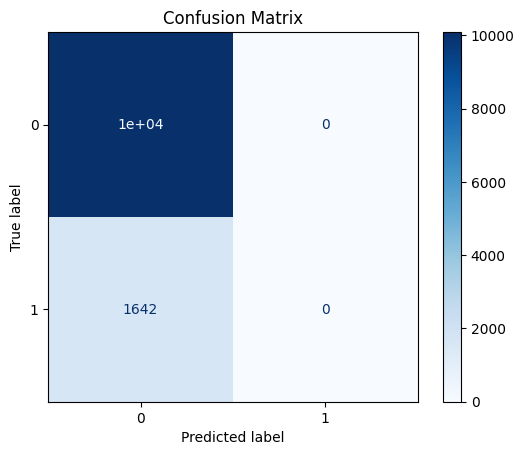

In [18]:
cm = confusion_matrix(y_val, y_val_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(8, 6))
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

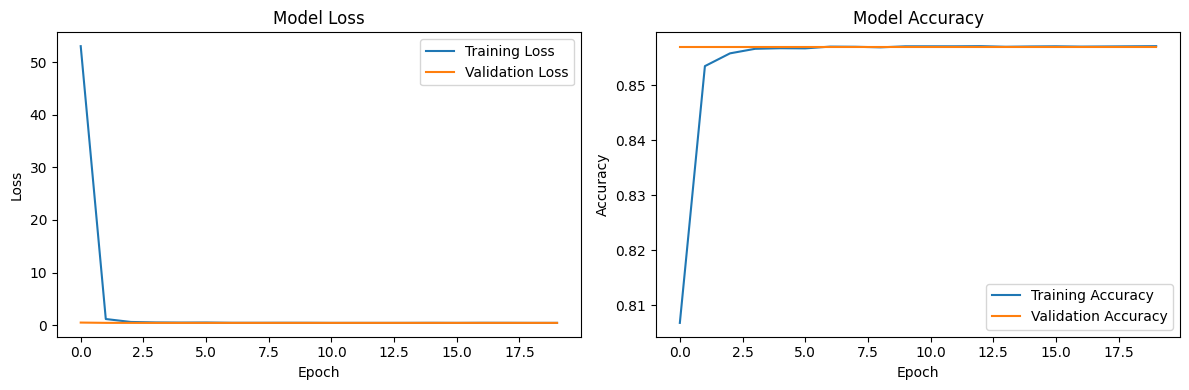

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()